## Notebook to Produce Results for the Pseudo Poisson Maximum Likelihood Post

In [6]:
## Libraries:
import pandas as pd 
import numpy as np

import pandas_profiling

from scipy.stats import norm
from sklearn.linear_model import LinearRegression

import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt 

# Running R from Python usin rpy2:
import rpy2.robjects as ro 
from rpy2.robjects import pandas2ri # pandas dataframe to r dataframe
pandas2ri.activate()



In [10]:
# Parameters:
B0 = -1.0
B1 = 2.0
M = 250 # monte carlo simulation size

# For bias in changing delta:
delta_list = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
n = 50

# Comparing OLS and PPML for changing sample size:
n_list = [10, 30, 50, 75, 100]
delta = 0.0001

In [3]:
# Vary delta with fixed n for the OLS model:

B1_hat = np.zeros(shape = (len(delta_list), M)) # we want to calculate the mean and standard error at each delta in delta_list

for m in range(M):
    Y = np.zeros(n)
    X = norm.rvs(loc = 0, scale = 1, size = n) # std dev = 1
    U = norm.rvs(loc = 0, scale = 1, size = n) #std dev = 1
    for i in range(n):
        if U[i] >= -0.7:
            Y[i] = np.exp(B0 + B1*X[i] + U[i])

    data = {'Y' : Y, 'X' : X}
    df = pd.DataFrame(data)

    for ix, delta in enumerate(delta_list):
        df['logY_delta'] = np.log(df['Y'] + delta) # take log of Y plus a constant to avoid log of zero 
        ols1 = LinearRegression().fit(df['X'].values.reshape(-1, 1), df['logY_delta'].values.reshape(-1,1))
        B1_hat[ix][m] = ols1.coef_[0][0] # extract the numnber from the ndarray


# Output the mean and standard error of each row in the ndarray:
delta_mean = np.mean(B1_hat, axis = 1) # axis = 1 takes the mean of each row (imagining as a matrix)
delta_std = np.std(B1_hat, axis = 1) # deviation of the monte carlo estimate - not the standard error of the coefficient estimate from the ols.
print(delta_mean, delta_std)

[1.55764322 1.55424259 1.55204826 1.54162188 1.53212311 1.48182009
 1.43908296 1.26054787 1.14426019 0.80432847 0.64789588] [0.70286305 0.60720805 0.56665701 0.47492601 0.43701366 0.35522319
 0.32359617 0.25973701 0.23593923 0.18541784 0.16410061]


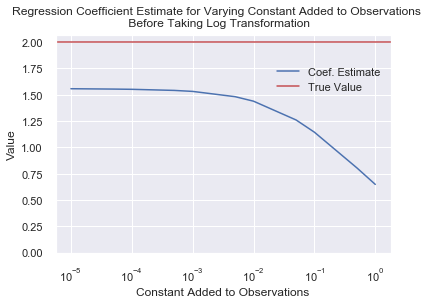

In [4]:
# Plot the mean and standard error bars at each delta in delta_list:
fig1, ax1 = plt.subplots()
fig1.suptitle('Regression Coefficient Estimate for Varying Constant Added to Observations \n Before Taking Log Transformation')
ax1.plot(delta_list, delta_mean, label = 'Coef. Estimate')
ax1.axhline(y=B1, color='r', linestyle='-', label = 'True Value')
ax1.set_ylim(ymin = 0)
ax1.set_xscale('log')
ax1.set_xlabel('Constant Added to Observations')
ax1.set_ylabel('Value')
ax1.legend(loc='upper right', bbox_to_anchor=(1.0, 0.9))

In [11]:
# Vary n with fixed delta for the OLS and fit PPML:

B1_hat_ols = np.zeros(shape = (len(n_list), M)) # we want to calculate the mean and standard error at each delta in delta_list
B1_hat_ppml = np.zeros(shape = (len(n_list), M))


for m in range(M):
    for idx, n in enumerate(n_list):
            Y = np.zeros(n)
            X = norm.rvs(loc = 0, scale = 1, size = n) # std dev = 1
            U = norm.rvs(loc = 0, scale = 1, size = n) #std dev = 1
            for i in range(n):
                if U[i] >= -0.7:
                    Y[i] = np.exp(B0 + B1*X[i] + U[i])

            data = {'Y' : Y, 'X' : X}
            df = pd.DataFrame(data)
    
            df['logY_delta'] = np.log(df['Y'] + delta) # take log of Y plus a constant to avoid log of zero 
            ols1 = LinearRegression().fit(df['X'].values.reshape(-1, 1), df['logY_delta'].values.reshape(-1,1))
            B1_hat_ols[idx][m] = ols1.coef_[0][0] # extract the numnber from the ndarray

            model_ppml = ro.r.glm('Y ~ X', data = df, family = ro.r('quasipoisson(link="log")'))
            B1_hat_ppml[idx][m] = model_ppml.rx2('coefficients')[1]


# Output the mean and standard error of each row in the ndarray:
ols_mean = np.mean(B1_hat_ols, axis = 1) # axis = 1 takes the mean of each row (imagining as a matrix)
ols_std = np.std(B1_hat_ols, axis = 1) # deviation of the monte carlo estimate - not the standard error of the coefficient estimate from the ols.
print(ols_mean, ols_std)

ppml_mean = np.mean(B1_hat_ppml, axis = 1) # axis = 1 takes the mean of each row (imagining as a matrix)
ppml_std = np.std(B1_hat_ppml, axis = 1) # deviation of the monte carlo estimate - not the standard error of the coefficient estimate from the ols.
print(ppml_mean, ppml_std)


[1.58946016 1.45924315 1.51999124 1.51941686 1.5218917 ] [1.5887202  0.73896252 0.58266828 0.45828532 0.41627127]
[1.75305345 1.84273653 1.94084369 1.94418052 1.90586286] [0.87604702 0.60800088 0.56102438 0.42561748 0.41640049]


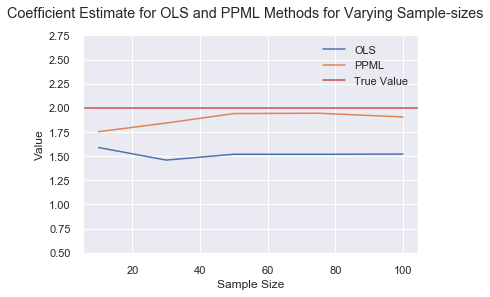

In [12]:
# Plot the mean and standard error bars at each sample size for both methods:
fig1, ax1 = plt.subplots()
fig1.suptitle('Coefficient Estimate for OLS and PPML Methods for Varying Sample-sizes')
ax1.plot(n_list, ols_mean, label = 'OLS')
ax1.plot(n_list, ppml_mean, label = 'PPML')
ax1.axhline(y=B1, color='r', linestyle='-', label = 'True Value')
ax1.set_ylim(0.5, 2.75)
ax1.set_xlabel('Sample Size')
ax1.set_ylabel('Value')
ax1.legend(loc='upper right')